Best parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}

Optimized KNN Accuracy: 87.46%

Classification Report:
                     precision    recall  f1-score   support

            ASSAULT       0.85      0.87      0.86     58589
            BATTERY       0.83      0.67      0.74     58589
           BURGLARY       0.92      0.99      0.95     58589
    CRIMINAL DAMAGE       0.85      0.81      0.83     58589
 DECEPTIVE PRACTICE       0.87      0.94      0.90     58589
MOTOR VEHICLE THEFT       0.86      0.90      0.88     58589
      OTHER OFFENSE       0.87      0.94      0.91     58589
            ROBBERY       0.91      0.99      0.95     58589
              THEFT       0.84      0.64      0.72     58589
  WEAPONS VIOLATION       0.92      0.99      0.95     58589

           accuracy                           0.87    585890
          macro avg       0.87      0.87      0.87    585890
       weighted avg       0.87      0.87      0.87    585890



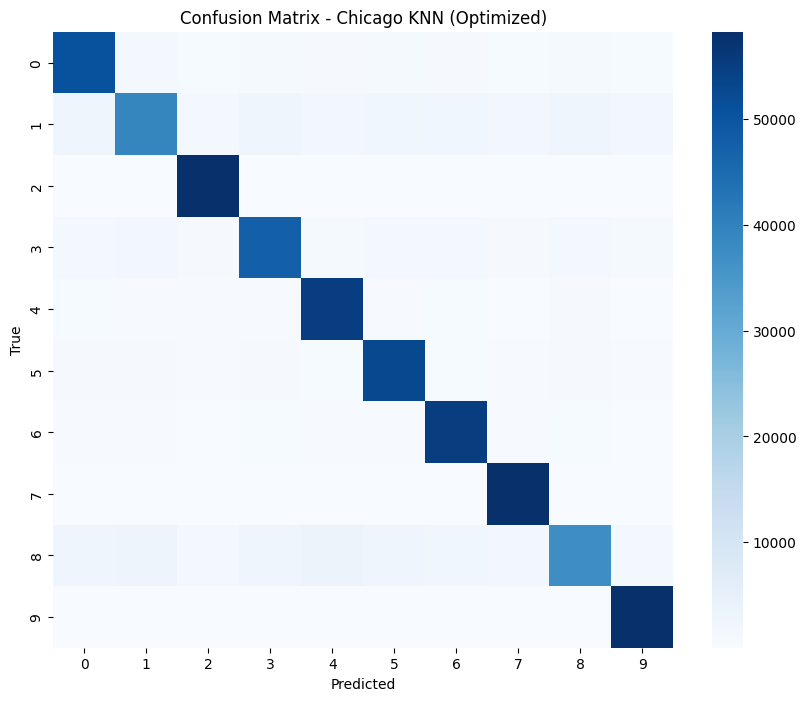

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv("../dataset/chicago_crime_features.csv")  


# ---- Keep top 10 most frequent crimes ----
top_crimes = df['Crime_Type'].value_counts().nlargest(10).index
df = df[df['Crime_Type'].isin(top_crimes)]

# ---- Select features ----
features = [
    'Latitude', 'Longitude', 'Zone', 'Hour', 'DayOfWeek',
    'IsWeekend', 'Light_Condition', 'Temperature', 'Rain'
]
X = df[features].copy()
y = df['Crime_Type']

# ---- Encode categorical columns (like DayOfWeek or Light_Condition) ----
for col in X.columns:
    if X[col].dtype == 'object':
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])

# ---- Balance classes ----
df_balanced = pd.concat([
    resample(df[df['Crime_Type'] == c],
             replace=True,
             n_samples=df['Crime_Type'].value_counts().max(),
             random_state=42)
    for c in top_crimes
])
X = df_balanced[features].copy()
y = df_balanced['Crime_Type']

for col in X.columns:
    if X[col].dtype == 'object':
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])

# ---- Encode target ----
target_le = LabelEncoder()
y_encoded = target_le.fit_transform(y)

# ---- Scale ----
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---- Split ----
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# ---- Grid Search ----
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}
grid = GridSearchCV(KNeighborsClassifier(), param_grid, scoring='accuracy', cv=3, n_jobs=-1)
grid.fit(X_train, y_train)

best_knn = grid.best_estimator_
print("Best parameters:", grid.best_params_)

# ---- Train & Evaluate ----
best_knn.fit(X_train, y_train)
y_pred = best_knn.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\nOptimized KNN Accuracy: {acc:.2%}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_le.classes_))

# ---- Confusion Matrix ----
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test, y_pred), cmap="Blues", annot=False)
plt.title("Confusion Matrix - Chicago KNN (Optimized)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [6]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))
print(classification_report(y_test, rf_pred, target_names=target_le.classes_))


Random Forest Accuracy: 0.6855877383126525
                     precision    recall  f1-score   support

            ASSAULT       0.60      0.64      0.62     58589
            BATTERY       0.76      0.41      0.53     58589
           BURGLARY       0.81      0.85      0.83     58589
    CRIMINAL DAMAGE       0.80      0.52      0.63     58589
 DECEPTIVE PRACTICE       0.58      0.81      0.68     58589
MOTOR VEHICLE THEFT       0.80      0.65      0.71     58589
      OTHER OFFENSE       0.71      0.72      0.71     58589
            ROBBERY       0.83      0.83      0.83     58589
              THEFT       0.67      0.50      0.57     58589
  WEAPONS VIOLATION       0.54      0.92      0.68     58589

           accuracy                           0.69    585890
          macro avg       0.71      0.69      0.68    585890
       weighted avg       0.71      0.69      0.68    585890



In [7]:
import lightgbm as lgb

lgbm = lgb.LGBMClassifier(
    num_leaves=31,
    max_depth=-1,
    learning_rate=0.1,
    n_estimators=200,
    objective='multiclass',
    random_state=42
)
lgbm.fit(X_train, y_train)
lgb_pred = lgbm.predict(X_test)

print("LightGBM Accuracy:", accuracy_score(y_test, lgb_pred))
print(classification_report(y_test, lgb_pred, target_names=target_le.classes_))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 813
[LightGBM] [Info] Number of data points in the train set: 2343560, number of used features: 9
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585


/Users/prateek/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM Accuracy: 0.23987267234463808
                     precision    recall  f1-score   support

            ASSAULT       0.17      0.17      0.17     58589
            BATTERY       0.22      0.05      0.08     58589
           BURGLARY       0.28      0.24      0.26     58589
    CRIMINAL DAMAGE       0.25      0.05      0.09     58589
 DECEPTIVE PRACTICE       0.25      0.49      0.33     58589
MOTOR VEHICLE THEFT       0.22      0.15      0.18     58589
      OTHER OFFENSE       0.20      0.17      0.18     58589
            ROBBERY       0.27      0.22      0.24     58589
              THEFT       0.28      0.29      0.29     58589
  WEAPONS VIOLATION       0.23      0.55      0.33     58589

           accuracy                           0.24    585890
          macro avg       0.24      0.24      0.22    585890
       weighted avg       0.24      0.24      0.22    585890



In [8]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000, n_jobs=-1)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_pred))
print(classification_report(y_test, lr_pred, target_names=target_le.classes_))


/Users/prateek/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Users/prateek/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Users/prateek/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Users/prateek/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:336: RuntimeWarning: divide by zero encountered in matmul
  grad[:, :n_features] = grad_pointwise.T @ X + l2_reg_strength * weights
/Users/prateek/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linea

Logistic Regression Accuracy: 0.16342316817149977
                     precision    recall  f1-score   support

            ASSAULT       0.13      0.20      0.16     58589
            BATTERY       0.11      0.00      0.00     58589
           BURGLARY       0.15      0.25      0.19     58589
    CRIMINAL DAMAGE       0.13      0.00      0.01     58589
 DECEPTIVE PRACTICE       0.18      0.36      0.24     58589
MOTOR VEHICLE THEFT       0.16      0.01      0.02     58589
      OTHER OFFENSE       0.13      0.08      0.10     58589
            ROBBERY       0.11      0.02      0.03     58589
              THEFT       0.18      0.27      0.22     58589
  WEAPONS VIOLATION       0.18      0.44      0.25     58589

           accuracy                           0.16    585890
          macro avg       0.15      0.16      0.12    585890
       weighted avg       0.15      0.16      0.12    585890



/Users/prateek/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/prateek/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/prateek/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [9]:
results = {
    "Model": ["KNN", "Random Forest", "LightGBM", "Logistic Regression"],
    "Accuracy": [
        accuracy_score(y_test, y_pred),  # KNN
        accuracy_score(y_test, rf_pred),
        accuracy_score(y_test, lgb_pred),
        accuracy_score(y_test, lr_pred)
    ]
}

comparison = pd.DataFrame(results)
print("\nModel Comparison:")
print(comparison)



Model Comparison:
                 Model  Accuracy
0                  KNN  0.874589
1        Random Forest  0.685588
2             LightGBM  0.239873
3  Logistic Regression  0.163423


/var/folders/40/xpskrwgs1l1734zl9j0227hw0000gn/T/ipykernel_48667/3223309771.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette="Blues_d")


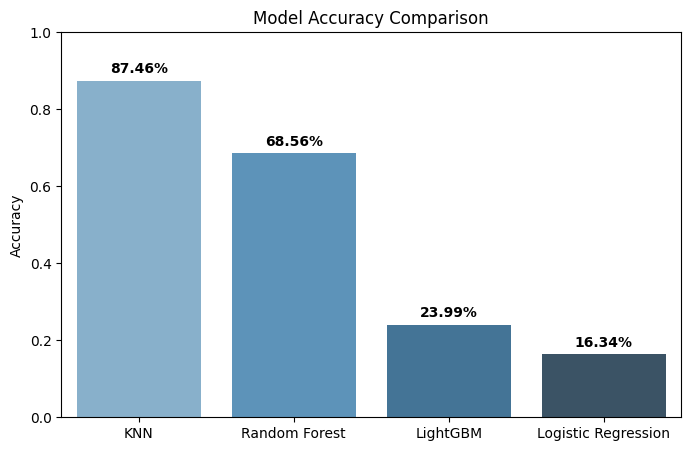

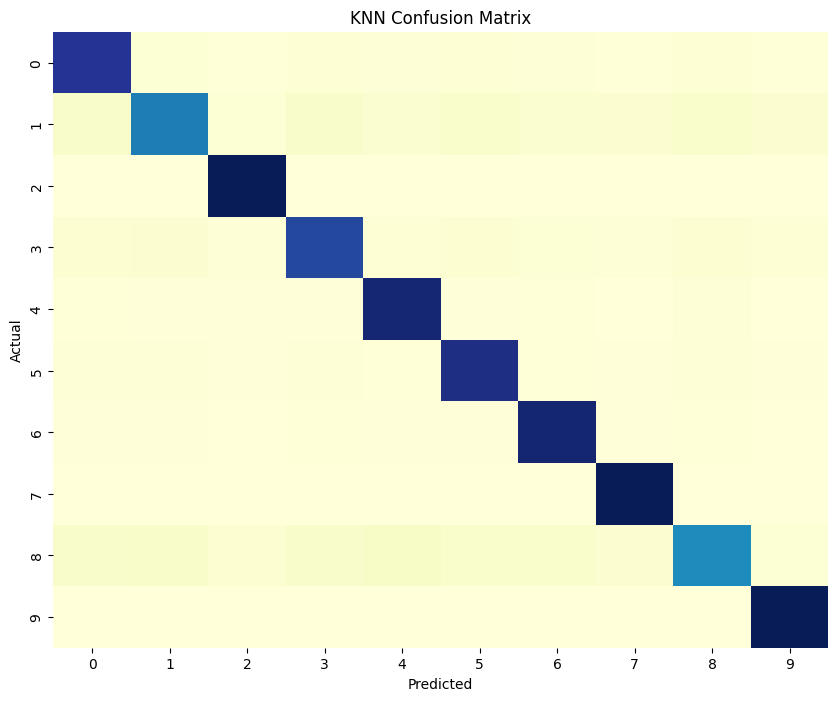

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Accuracy Bar Chart ---
models = ["KNN", "Random Forest", "LightGBM", "Logistic Regression"]
accuracies = [
    accuracy_score(y_test, y_pred),       # KNN
    accuracy_score(y_test, rf_pred),
    accuracy_score(y_test, lgb_pred),
    accuracy_score(y_test, lr_pred)
]

plt.figure(figsize=(8,5))
sns.barplot(x=models, y=accuracies, palette="Blues_d")
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0,1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f"{v:.2%}", ha='center', fontweight='bold')
plt.show()

# --- Confusion Matrix for KNN (best model) ---
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, cmap="YlGnBu", cbar=False)
plt.title("KNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [11]:
import joblib

# Save KNN model
joblib.dump(best_knn, "../models/knn_chicago.pkl")

# Save scaler
joblib.dump(scaler, "../models/scaler_chicago.pkl")

print("✅ KNN model and scaler saved successfully!")


✅ KNN model and scaler saved successfully!


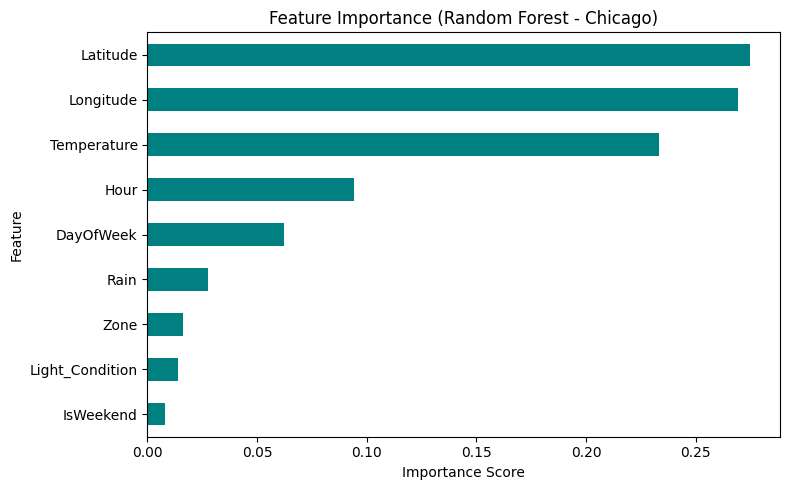

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Get importance scores
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=features).sort_values(ascending=True)

# Plot
plt.figure(figsize=(8,5))
feat_imp.plot(kind='barh', color='teal')
plt.title("Feature Importance (Random Forest - Chicago)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [13]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=target_le.classes_, columns=target_le.classes_)
cm_df["Most Confused With"] = cm_df.apply(lambda row: row.drop(row.name).idxmax(), axis=1)
print("Top Confusions:")
print(cm_df["Most Confused With"].head(10))


Top Confusions:
ASSAULT                           BATTERY
BATTERY                   CRIMINAL DAMAGE
BURGLARY                            THEFT
CRIMINAL DAMAGE                   BATTERY
DECEPTIVE PRACTICE                  THEFT
MOTOR VEHICLE THEFT               BATTERY
OTHER OFFENSE             CRIMINAL DAMAGE
ROBBERY                           BATTERY
THEFT                  DECEPTIVE PRACTICE
WEAPONS VIOLATION                 BATTERY
Name: Most Confused With, dtype: object
